In [14]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../stimulus_core/')
sys.path.append('../models_core/')
sys.path.append('../helper/')

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R3d
import imageio
import time
import importlib
import glob
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy
from PIL import Image
from time import sleep
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

import dynamics_3d as dn3d
import optical_signal as opsg
import predefined_weights as pdwt
import samples_generation_multi_units as smgnmu
import flow_field as flfd
import helper_functions as hpfn
import get_Klapoetke_stimuli as gKs

In [15]:
figure_path = '/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    

# Model Clustering

Here, we cluster the model with respective the trained excitatory and inhibitory weights.

In [3]:
# Generate folders that will store the results of the clustering

has_inhibition = True
save_path = figure_path+'model_clustering/'
if not os.path.exists(save_path+'trained_filters/'):
    os.makedirs(save_path+'trained_filters/')
if not os.path.exists(save_path+'clusterings/'):
    os.makedirs(save_path+'clusterings/')
if not os.path.exists(save_path+'auc_scores/'):
    os.makedirs(save_path+'auc_scores/')

In [68]:
# Load the data, one needs to change M that represents number of units in the model

M = 1
# result_folder = '/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/\
# set_{}_R1.0/inhibitory2/ACT_0_0.001/'.format(np.int(1000+M))
result_folder = f'/Volumes/Baohua/research_large_files/multi_lplc2_training_D5/\
M_{M}/lr_0.001/regu_0.0001/'

subdir_all = []
for subdir, dirs, files in os.walk(result_folder):
    subdir_all.append(subdir)
subdir_all.pop(0)
filename = save_path+'clusterings/subdir_all_M{}'.format(M)
np.save(filename, subdir_all)


In [69]:
# The hierachical clustering is used for the cluster.

effective_weights = np.concatenate((np.arange(4, 8), np.arange(14, 22), np.arange(25, 35), \
                                    np.arange(37, 47), np.arange(48, 72))) # for getting rid of corners
trained_weights_e_all = []
trained_weights_i_all = []
auc_scores = []
loss_output_all = []
y_scores = []
y_trues = []
for subdir in subdir_all:
    if os.path.exists(subdir+'/auc_roc.npy'):
        trained_weights_e = np.load(subdir+'/trained_weights_e.npy')
        auc_pr = np.load(subdir+'/auc_pr.npy')
        auc_roc = np.load(subdir+'/auc_roc.npy')
        y_score = np.load(subdir+'/y_pred_test.npy')
        y_true = np.load(subdir+'/y_true_test.npy')
        loss_output = np.load(subdir+'/train_loss_output.npy')
        trained_weights_e_all.append(trained_weights_e)
        auc_scores.append([auc_pr, auc_roc])
        y_scores.append(y_score)
        y_trues.append(y_true)
        loss_output_all.append(loss_output)
        if has_inhibition:
            trained_weights_i = np.load(subdir+'/trained_weights_i.npy')
            trained_weights_i_all.append(trained_weights_i)
trained_weights_e_all = np.array(trained_weights_e_all)[:, :, 0]
trained_weights_e_all_c = np.array(trained_weights_e_all)[:, effective_weights]
auc_scores = np.array(auc_scores)
y_scores = np.array(y_scores)
y_trues = np.array(y_trues)
loss_output_all = np.array(loss_output_all)
if has_inhibition:
    trained_weights_i_all = np.array(trained_weights_i_all)[:, :, 0]
    trained_weights_i_all_c = np.array(trained_weights_i_all)[:, effective_weights]
    trained_weights_all_c = np.concatenate((trained_weights_e_all_c, trained_weights_i_all_c), axis=1)
else:
    trained_weights_all_c = trained_weights_e_all_c

cos_similarity = cosine_similarity(trained_weights_all_c, trained_weights_all_c)
cos_similarity = np.clip(cos_similarity, 0., 1.)
cos_distance = 1-cos_similarity

trained_weights_all_s = np.zeros_like(trained_weights_all_c)
for ii in range(trained_weights_all_c.shape[0]):
    trained_weights_all_s[ii, :] = trained_weights_all_c[ii, :]+1e-30

threshold = 0.2
Z = hierarchy.linkage(trained_weights_all_s[:, :], metric='cosine')
C = hierarchy.fcluster(Z, threshold, criterion="distance")
print(np.unique(C))
NC = len(np.unique(C))

[1 2 3 4 5]


Cluster label:  1 Cluster size:  3


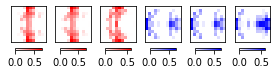

Cluster label:  2 Cluster size:  2


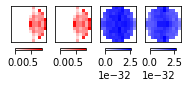

Cluster label:  3 Cluster size:  40


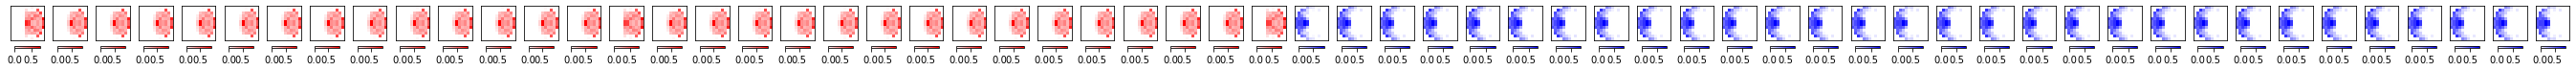

Cluster label:  4 Cluster size:  60


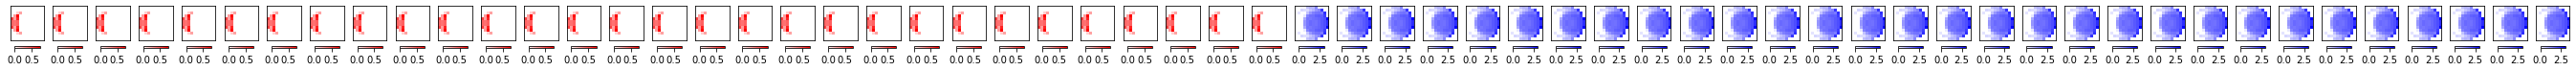

Cluster label:  5 Cluster size:  95


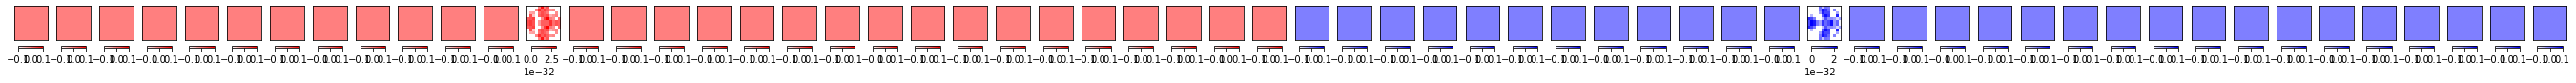

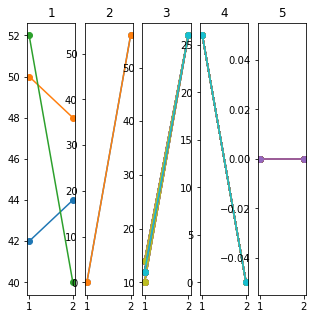

In [70]:
# Visualize the clustered weights to examine them by eyes.

importlib.reload(hpfn)

K = 12
n_sample = 30 # the largest number of sample weights to show for each cluster
mask_d = opsg.get_disk_mask(K, 4)
if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
for label in range(1, NC+1):
    print('Cluster label: ', label, 'Cluster size: ', (C==label).sum())
    sample_array = np.where(C==label)[0]
    sample_list = list(sample_array[:n_sample])
    fig = hpfn.display_weights(K, trained_weights_e_all, trained_weights_i_all, has_inhibition, sample_list, n_sample, mask_d, colormap_e, colormap_i)
    filename = save_path+'trained_filters/filters_M{}_{}.pdf'.format(M, label)
    fig.savefig(filename, bbox_inches='tight')
    
    
# check left and right half of the filters
left_right_compare = np.zeros(len(C))
left_right_compare_unique = np.zeros(NC)
fig = plt.figure(figsize=(NC, 5))
gs0 = gridspec.GridSpec(1, NC, figure=fig)
for label in range(1, NC+1):
    sample_array = np.where(C==label)[0]
    sample_list = list(sample_array[:])
    for sample in sample_list:
        trained_weight_e = trained_weights_e_all[sample].reshape((K, K))
        trained_weight_e[mask_d] = 0
        trained_weight_e[trained_weight_e<1e-3] = 0
        trained_weight_e_left = (trained_weight_e[:, :6]>1e-4).sum()
        trained_weight_e_right = (trained_weight_e[:, 6:]>1e-4).sum()
#         trained_weight_e_left = trained_weight_e[:, :6].sum()
#         trained_weight_e_right = trained_weight_e[:, 6:].sum()
        if trained_weight_e_left == trained_weight_e_right:
            left_right_compare[sample] = -1
        elif trained_weight_e_left < trained_weight_e_right:
            left_right_compare[sample] = 1
        elif trained_weight_e_left > trained_weight_e_right:
            left_right_compare[sample] = 0
        ax = fig.add_subplot(gs0[0, label-1])
        ax.plot([1, 2], [trained_weight_e_left, trained_weight_e_right], 'o-')
        ax.set_title(label)
    left_right_compare_unique[label-1] = np.round(left_right_compare[sample_list].mean())

In [71]:
# Check the model cluster size: 1--outward, 0--inward, -1--unstructured

print(f'Outward: {(left_right_compare == 1).sum()}')
print(f'Inward: {(left_right_compare == 0).sum()}')
print(f'Unstructured: {(left_right_compare == -1).sum()}')

Outward: 43
Inward: 62
Unstructured: 95


In [72]:
# 'm': outward; 'g': inward; 'k': others/unstructured

color_dict_tem = {}
color_dict_tem[1] = 'm'
color_dict_tem[0] = 'g'
color_dict_tem[-1] = 'k'

color_list = [color_dict_tem[ii] for ii in list(left_right_compare)]
color_list_unique = [color_dict_tem[ii] for ii in list(left_right_compare_unique)]
# print(color_list)
# print(color_list_unique)

In [73]:
# save the clustering results

# trained weights for clustering
filename = save_path+'clusterings/trained_weights_all_c_M{}'.format(M)
np.save(filename, trained_weights_all_c)

# hierarchical linkage
filename = save_path+'clusterings/Z_M{}'.format(M)
np.save(filename, Z)

# clusters
filename = save_path+'clusterings/C_M{}'.format(M)
np.save(filename, C)

# color list
filename = save_path+'clusterings/color_list_M{}'.format(M)
np.save(filename, color_list)

# color list unique
filename = save_path+'clusterings/color_list_unique_M{}'.format(M)
np.save(filename, color_list_unique)

# label dict
label_dict = {}
label_dict['m'] = []
label_dict['g'] = []
label_dict['k'] = []
for jj in range(len(C)):
    if color_list[jj] == 'm':
        label_dict['m'].append(jj)
    elif color_list[jj] == 'g':
        label_dict['g'].append(jj)
    elif color_list[jj] == 'k':
        label_dict['k'].append(jj)
filename = save_path+'clusterings/label_dict_M{}'.format(M)
np.save(filename, label_dict)

# the cluster size
total_cases = len(C)
outward_cases = len(label_dict['m'])
inward_cases = len(label_dict['g'])
cluster_size = np.array([M, total_cases, outward_cases, inward_cases])
filename = save_path+'clusterings/cluster_size_M{}'.format(M)
np.save(filename, cluster_size)
print('The M value is: ', M)
print('Total cases are: ', total_cases)
print('The number of outward cases are: ', outward_cases)
print('The number of inward cases are: ', inward_cases)

# model folders
model_folders_outward = []
model_folders_inward = []
model_folders_others = []
for jj in range(len(C)):
    if color_list[jj] == 'm':
        model_folders_outward.append(subdir_all[jj])
    elif color_list[jj] == 'g':
        model_folders_inward.append(subdir_all[jj])
    elif color_list[jj] == 'k':
        model_folders_others.append(subdir_all[jj])
model_folders = [model_folders_outward, model_folders_inward, model_folders_others]
filename = save_path+'clusterings/model_folders_M{}'.format(M)
np.save(filename, model_folders)

The M value is:  1
Total cases are:  200
The number of outward cases are:  43
The number of inward cases are:  62


In [74]:
# save the auc scores
auc_scores_outward = auc_scores[label_dict['m'], :]
auc_scores_inward = auc_scores[label_dict['g'], :]
filename = save_path+'auc_scores/auc_scores_M{}'.format(M)
np.save(filename, auc_scores)
filename = save_path+'auc_scores/auc_scores_outward_M{}'.format(M)
np.save(filename, auc_scores_outward)
filename = save_path+'auc_scores/auc_scores_inward_M{}'.format(M)
np.save(filename, auc_scores_inward)

# save the y scores
y_scores_outward = y_scores[label_dict['m'], :]
y_scores_inward = y_scores[label_dict['g'], :]
filename = save_path+'auc_scores/y_scores_M{}'.format(M)
np.save(filename, y_scores)
filename = save_path+'auc_scores/y_scores_outward_M{}'.format(M)
np.save(filename, y_scores_outward)
filename = save_path+'auc_scores/y_scores_inward_M{}'.format(M)
np.save(filename, y_scores_inward)

# save the y trues
y_trues_outward = y_trues[label_dict['m'], :]
y_trues_inward = y_trues[label_dict['g'], :]
filename = save_path+'auc_scores/y_trues_M{}'.format(M)
np.save(filename, y_trues)
filename = save_path+'auc_scores/y_trues_outward_M{}'.format(M)
np.save(filename, y_trues_outward)
filename = save_path+'auc_scores/y_trues_inward_M{}'.format(M)
np.save(filename, y_trues_inward)

# Response vs distance

Here, we look at reponses of the trained models.

In [13]:
if not os.path.exists(figure_path+'response_vs_distance/'):
    os.makedirs(figure_path+'response_vs_distance/')

In [12]:
importlib.reload(hpfn)

M = 32
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)

# model
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.

set_number = np.int(1000+M)
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/'.format(set_number)
data_types = ['hit', 'miss', 'retreat', 'rotation']

model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]

dt = 0.01
sample_dt = 0.03
bin_size_a = 5
bin_size_d = 0.2
max_angle = 180

# outward
filter_type = filter_types[0]
model_path = model_folders[0][0]+'/'
data_type = data_types[0]
res_max_all_hit_n, res_T_all_hit_n, angles_all_hit_n, steps_hit_n, distances_all_hit_n = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_hit_n, res_T_all_hit_n, angles_all_hit_n, steps_hit_n, distances_all_hit_n)
data_type = data_types[1]
res_max_all_miss_n, res_T_all_miss_n, angles_all_miss_n, steps_miss_n, distances_all_miss_n = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_miss_n, res_T_all_miss_n, angles_all_miss_n, steps_miss_n, distances_all_miss_n)
data_type = data_types[2]
res_max_all_retreat_n, res_T_all_retreat_n, angles_all_retreat_n, steps_retreat_n, distances_all_retreat_n = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_retreat_n, res_T_all_retreat_n, angles_all_retreat_n, steps_retreat_n, distances_all_retreat_n)

res_heatmap_hit_n = hpfn.generate_heatmap_multiunit_dist(res_T_all_hit_n, angles_all_hit_n, distances_all_hit_n, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
res_heatmap_miss_n = hpfn.generate_heatmap_multiunit_dist(res_T_all_miss_n, angles_all_miss_n, distances_all_miss_n, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
res_heatmap_retreat_n = hpfn.generate_heatmap_multiunit_dist(res_T_all_retreat_n, angles_all_retreat_n, distances_all_retreat_n, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}'.format(M)
np.savez(save_file, res_heatmap_hit_n, res_heatmap_miss_n, res_heatmap_retreat_n)

# inward
filter_type = filter_types[1]
model_path = model_folders[1][0]+'/'
data_type = data_types[0]
res_max_all_hit_r, res_T_all_hit_r, angles_all_hit_r, steps_hit_r, distances_all_hit_r = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_hit_r, res_T_all_hit_r, angles_all_hit_r, steps_hit_r, distances_all_hit_r)
data_type = data_types[1]
res_max_all_miss_r, res_T_all_miss_r, angles_all_miss_r, steps_miss_r, distances_all_miss_r = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_miss_r, res_T_all_miss_r, angles_all_miss_r, steps_miss_r, distances_all_miss_r)
data_type = data_types[2]
res_max_all_retreat_r, res_T_all_retreat_r, angles_all_retreat_r, steps_retreat_r, distances_all_retreat_r = hpfn.generate_response_multiunit(args, model_path, model_type, data_path, data_type)
save_file = figure_path+'response_vs_distance/'+'results'+'_'+filter_type+'_'+data_type+'_M{}'.format(M)
np.savez(save_file, res_max_all_retreat_r, res_T_all_retreat_r, angles_all_retreat_r, steps_retreat_r, distances_all_retreat_r)

res_heatmap_hit_r = hpfn.generate_heatmap_multiunit_dist(res_T_all_hit_r, angles_all_hit_r, distances_all_hit_r, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
res_heatmap_miss_r = hpfn.generate_heatmap_multiunit_dist(res_T_all_miss_r, angles_all_miss_r, distances_all_miss_r, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
res_heatmap_retreat_r = hpfn.generate_heatmap_multiunit_dist(res_T_all_retreat_r, angles_all_retreat_r, distances_all_retreat_r, bin_size_a, bin_size_d, max_angle, dt, sample_dt)
save_file = figure_path+'response_vs_distance/'+'heatmap'+'_'+filter_type+'_M{}'.format(M)
np.savez(save_file, res_heatmap_hit_r, res_heatmap_miss_r, res_heatmap_retreat_r)



KeyboardInterrupt: 

# Sparse and dense response

In [24]:
importlib.reload(hpfn)

if not os.path.exists(figure_path+'sparse_and_dense/'):
    os.makedirs(figure_path+'sparse_and_dense/')

for M in [1, 2, 4, 8, 16, 32, 64, 128, 192, 256]:
    K = 12
    L = 4
    KK = K**2
    pad = 2*L
    NNs = 10
    set_number = np.int(1000+M)
    data_path = figure_path+'model_clustering/clusterings/'
    model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
    data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/'.format(set_number)
    data_types = ['hit', 'miss', 'retreat', 'rotation']

    args = {}
    args["n"] = 0
    args["dt"] = 0.03
    args["use_intensity"] = False
    args["symmetrize"] = True
    args['K'] = 12
    args['alpha_leak'] = 0.0
    args['M'] = M
    args['temporal_filter'] = False
    args['tau_1'] = 1.
    model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2', 'linear']
    model_type = model_types[3]

    filter_types = ['outward', 'inward']

    for ind, filter_type in enumerate(filter_types):

        model_path = model_folders[ind][0]+'/'
        prob_mean_ = []
        prob_max_ = []
        prob_all_ = []
        res_T_all_ = []
        dist_min_ = []
        prob_rest_ = []
        res_rest_ = []
        for data_type in data_types:
            prob_mean_tem = []
            prob_max_tem = []
            prob_all_tem = []
            res_T_all_tem = []
            dist_min_tem = []
            if data_type == 'hit':
                snn1 = 0
                snn2 = 1000
                pre_N = 0
            elif data_type == 'miss':
                snn1 = 0
                snn2 = 500
                pre_N = 0
            elif data_type == 'retreat':
                snn1 = 0
                snn2 = 500
                pre_N = 0
            elif data_type == 'rotation':
                snn1 = 0
                snn2 = 2000
                pre_N = 0
            for sn in range(snn1, snn2):
                # load data
                sample_number = sn
                sample_list_number = np.int((pre_N+sample_number)//NNs+1)
                path = data_path+'training'+'/'+data_type+'/'
                UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_{}.npy'.format(sample_list_number), allow_pickle=True)
                UV_flow_sample = UV_flow_sample_list[sample_number%NNs-1]
                if data_type == 'miss':
                    path_dist = data_path+'other_info'+'/'+data_type+'/'+'distances/'
                    dist_list = np.load(path_dist+'distance_list_{}.npy'.format(sample_list_number), allow_pickle=True)
                    dist = dist_list[sample_number%NNs-1]
                    dist_min_tem.append(dist.min())
                elif data_type == 'hit':
                    dist_min_tem.append(0.)
                elif data_type == 'retreat':
                    dist_min_tem.append(7.)
                else:
                    dist_min_tem.append(6.)

                # get res and prob
                res_rest, res_T, prob, prob_rest = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample)
                res_T_all_tem.append(res_T)
                prob_mean_tem.append(prob.mean())
                prob_max_tem.append(prob.max())
                prob_all_tem.append(prob)

            dist_min_.append(dist_min_tem)
            res_T_all_.append(res_T_all_tem)
            prob_mean_.append(prob_mean_tem)
            prob_max_.append(prob_max_tem)
            prob_all_.append(prob_all_tem)
            prob_rest_.append(prob_rest)
            res_rest_.append(res_rest)

        save_file = figure_path+'sparse_and_dense/'+'results'+'_'+filter_type+'_M{}'.format(M)
        np.savez(save_file, dist_min_, res_T_all_, res_rest_, prob_mean_, prob_max_, prob_all_, prob_rest_)




In [27]:
importlib.reload(hpfn)

## Sparse and dense activity
sparse_dense_hit_out = []
sparse_dense_miss_out = []
sparse_dense_retreat_out = []
sparse_dense_rotation_out = []
sparse_dense_hit_in = []
sparse_dense_miss_in = []
sparse_dense_retreat_in = []
sparse_dense_rotation_in = []

M_list = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256]
M_list_np = np.array(M_list)
filter_types = ['outward', 'inward']

for M in M_list:
    ## outward
    filter_type = filter_types[0]
    save_file = figure_path+'sparse_and_dense/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
    loaded_file = np.load(save_file, allow_pickle=True)
    dist_min_n = loaded_file['arr_0']
    res_T_all_n = loaded_file['arr_1']
    res_rest_n = loaded_file['arr_2']
    prob_mean_n = loaded_file['arr_3']
    # hit
    data_type_ind = 0
    M_active = hpfn.get_sparsity(M, res_T_all_n, res_rest_n, data_type_ind)
    sparse_dense_hit_out.append(M_active)
    # miss
    data_type_ind = 1
    M_active = hpfn.get_sparsity(M, res_T_all_n, res_rest_n, data_type_ind)
    sparse_dense_miss_out.append(M_active)
    # retreat
    data_type_ind = 2
    M_active = hpfn.get_sparsity(M, res_T_all_n, res_rest_n, data_type_ind)
    sparse_dense_retreat_out.append(M_active)
    # rotation
    data_type_ind = 3
    M_active = hpfn.get_sparsity(M, res_T_all_n, res_rest_n, data_type_ind)
    sparse_dense_rotation_out.append(M_active)

    ## inward
    filter_type = filter_types[1]
    save_file = figure_path+'sparse_and_dense/'+'results'+'_'+filter_type+'_M{}.npz'.format(M)
    loaded_file = np.load(save_file, allow_pickle=True)
    dist_min_r = loaded_file['arr_0']
    res_T_all_r = loaded_file['arr_1']
    res_rest_r = loaded_file['arr_2']
    prob_mean_r = loaded_file['arr_3']
    # hit
    data_type_ind = 0
    M_active = hpfn.get_sparsity(M, res_T_all_r, res_rest_r, data_type_ind)
    sparse_dense_hit_in.append(M_active)
    # miss
    data_type_ind = 1
    M_active = hpfn.get_sparsity(M, res_T_all_r, res_rest_r, data_type_ind)
    sparse_dense_miss_in.append(M_active)
    # retreat
    data_type_ind = 2
    M_active = hpfn.get_sparsity(M, res_T_all_r, res_rest_r, data_type_ind)
    sparse_dense_retreat_in.append(M_active)
    # rotation
    data_type_ind = 3
    M_active = hpfn.get_sparsity(M, res_T_all_r, res_rest_r, data_type_ind)
    sparse_dense_rotation_in.append(M_active)

sparse_dense_hit_out = np.array(sparse_dense_hit_out)
sparse_dense_miss_out = np.array(sparse_dense_miss_out)
sparse_dense_retreat_out = np.array(sparse_dense_retreat_out)
sparse_dense_rotation_out = np.array(sparse_dense_rotation_out)
sparse_dense_hit_in = np.array(sparse_dense_hit_in)
sparse_dense_miss_in = np.array(sparse_dense_miss_in)
sparse_dense_retreat_in = np.array(sparse_dense_retreat_in)
sparse_dense_rotation_in = np.array(sparse_dense_rotation_in)

save_file = figure_path+'sparse_and_dense/'

np.save(save_file+'sparse_dense_hit_out', sparse_dense_hit_out)
np.save(save_file+'sparse_dense_miss_out', sparse_dense_miss_out)
np.save(save_file+'sparse_dense_retreat_out', sparse_dense_retreat_out)
np.save(save_file+'sparse_dense_rotation_out', sparse_dense_rotation_out)
np.save(save_file+'sparse_dense_hit_in', sparse_dense_hit_in)
np.save(save_file+'sparse_dense_miss_in', sparse_dense_miss_in)
np.save(save_file+'sparse_dense_retreat_in', sparse_dense_retreat_in)
np.save(save_file+'sparse_dense_rotation_in', sparse_dense_rotation_in)

# Probability of hit

Here, we look at the predicted probability of hit given certain models.

In [3]:
if not os.path.exists(figure_path+'probability_of_hit/'):
    os.makedirs(figure_path+'probability_of_hit/')

In [42]:
importlib.reload(hpfn)

M = 32
K = 12
L = 4
KK = K**2
pad = 2*L
NNs = 10
set_number = np.int(1000+M)
data_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/'.format(set_number)
data_types = ['hit', 'miss', 'retreat', 'rotation']

args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2', 'linear']
model_type = model_types[3]

filter_types = ['outward', 'inward']

for ind, filter_type in enumerate(filter_types):

    model_path = model_folders[ind][0]+'/'
    print(filter_type, model_path)
    prob_mean_ = []
    prob_max_ = []
    prob_all_ = []
    res_T_all_ = []
    dist_min_ = []
    prob_rest_ = []
    for data_type in data_types:
        prob_mean_tem = []
        prob_max_tem = []
        prob_all_tem = []
        res_T_all_tem = []
        dist_min_tem = []
        if data_type == 'hit':
            snn1 = 0
            snn2 = 300
            pre_N = 1000
        elif data_type == 'miss':
            snn1 = 0
            snn2 = 150
            pre_N = 500
        elif data_type == 'retreat':
            snn1 = 0
            snn2 = 150
            pre_N = 500
        elif data_type == 'rotation':
            snn1 = 0
            snn2 = 600
            pre_N = 2000
        for sn in range(snn1, snn2):
            # load data
            sample_number = sn
            sample_list_number = np.int((pre_N+sample_number)//NNs+1)
            path = data_path+'testing'+'/'+data_type+'/'
            UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_{}.npy'.format(sample_list_number), allow_pickle=True)
            UV_flow_sample = UV_flow_sample_list[sample_number%NNs-1]
            if data_type == 'miss':
                path_dist = data_path+'other_info'+'/'+data_type+'/'+'distances/'
                dist_list = np.load(path_dist+'distance_list_{}.npy'.format(sample_list_number), allow_pickle=True)
                dist = dist_list[sample_number%NNs-1]
                dist_min_tem.append(dist.min())
            elif data_type == 'hit':
                dist_min_tem.append(0.)
            elif data_type == 'retreat':
                dist_min_tem.append(7.)
            else:
                dist_min_tem.append(6.)

            # get res and prob
            res_rest, res_T, prob, prob_rest = hpfn.get_response_over_time(args, model_path, model_type, UV_flow_sample)
            res_T_all_tem.append(res_T)
            prob_mean_tem.append(prob.mean())
            prob_max_tem.append(prob.max())
            prob_all_tem.append(prob)

        dist_min_.append(dist_min_tem)
        res_T_all_.append(res_T_all_tem)
        prob_mean_.append(prob_mean_tem)
        prob_max_.append(prob_max_tem)
        prob_all_.append(prob_all_tem)
        prob_rest_.append(prob_rest)

    save_file = figure_path+'probability_of_hit/'+'results'+'_'+filter_type+'_M{}'.format(M)
    np.savez(save_file, dist_min_, res_T_all_, prob_mean_, prob_max_, prob_all_, prob_rest_)




outward /Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/set_1032_R1.0/inhibitory2/ACT_0_0.001/False_False_102_20201221005123/
inward /Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/set_1032_R1.0/inhibitory2/ACT_0_0.001/False_False_108_20201221005123/


# Grid response

Here, we look at the responses of the trained models to a grid of incoming hit signals.

In [46]:
if not os.path.exists(figure_path+'grid_response/'):
    os.makedirs(figure_path+'grid_response/')
print(figure_path)

/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper/


In [76]:
M = 256

# response, outward filters
model_folders = np.load(figure_path + '/model_clustering/clusterings/model_folders_M{}.npy'.format(M), \
                        allow_pickle=True)
# model
in_or_out = 0 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][16]+'/'
print(model_path)
data_path = '/Volumes/Baohua/data_on_hd/loom/grid_conv2_M1_L100_par/'

res_rest_all = []
res_T_all = []
prob_all = []
prob_rest_all = []
for i in range(31):
    res_rest_tem = []
    res_T_tem = []
    prob_tem = []
    prob_rest_tem = []
    for j in range(72):
        file = glob.glob(data_path+'UV_flow_samples/'+'UV_flow_sample_{}_{}.npy'.format(i+1, j+1))
        UV_flow = np.load(file[0], allow_pickle=True)[0]
        res_rest, res_T, prob, prob_rest = hpfn.get_response_over_time(args, model_path, model_type, UV_flow, intensity=0)
        res_rest_tem.append(res_rest)
        res_T_tem.append(res_T)
        prob_tem.append(prob)
        prob_rest_tem.append(prob_rest)
    res_rest_all.append(res_rest_tem)
    res_T_all.append(res_T_tem)
    prob_all.append(prob_tem)
    prob_rest_all.append(prob_rest_tem)
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}'.format(M)
np.savez(save_file, res_rest_all, res_T_all, prob_rest_all, prob_all)


# response, inward filters
model_folders = np.load(figure_path + '/model_clustering/clusterings/model_folders_M{}.npy'.format(M), \
                        allow_pickle=True)
# model
in_or_out = 1 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][0]+'/'
data_path = '/Volumes/Baohua/data_on_hd/loom/grid_conv2_M1_L100_par/'

res_rest_all = []
res_T_all = []
prob_all = []
prob_rest_all = []
for i in range(31):
    res_rest_tem = []
    res_T_tem = []
    prob_tem = []
    prob_rest_tem = []
    for j in range(72):
        file = glob.glob(data_path+'UV_flow_samples/'+'UV_flow_sample_{}_{}.npy'.format(i+1, j+1))
        UV_flow = np.load(file[0], allow_pickle=True)[0]
        res_rest, res_T, prob, prob_rest = hpfn.get_response_over_time(args, model_path, model_type, UV_flow, intensity=0)
        res_rest_tem.append(res_rest)
        res_T_tem.append(res_T)
        prob_tem.append(prob)
        prob_rest_tem.append(prob_rest)
    res_rest_all.append(res_rest_tem)
    res_T_all.append(res_T_tem)
    prob_all.append(prob_tem)
    prob_rest_all.append(prob_rest_tem)
save_file = figure_path+'grid_response/'+'results'+'_'+filter_type+'_M{}'.format(M)
np.savez(save_file, res_rest_all, res_T_all, prob_rest_all, prob_all)
        

/Volumes/Baohua/research_large_files/multi_lplc2_training_D5/M_256/lr_0.001/regu_0.0001/seed_156_20210619111917/


KeyboardInterrupt: 

In [111]:
np.array(prob_all).shape

(31, 72)

# Calculate theta

Here, we calculate the incoming theta angles of the isotropic hit signals.

In [20]:
print(figure_path)

/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper/


In [21]:
if not os.path.exists(figure_path+'theta_angles/'):
    os.makedirs(figure_path+'theta_angles/')

In [22]:
theta_angles = []
for sn in range(1000):
    # data
    K = 12
    L = 4
    KK = K**2
    pad = 2*L
    set_number = 1001
    NNs = 10
    data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/'.format(set_number)
    data_types = ['hit', 'miss', 'retreat', 'rotation']
    data_type = data_types[0]
    sample_number = sn
    sample_list_number = sample_number//NNs+1
    path = data_path+'training'+'/'+data_type+'/'
    frames_sample_cg_list = np.load(path+'frames_samples_cg/frames_sample_cg_list_{}.npy'.format(sample_list_number), allow_pickle=True)
    UV_flow_sample_list = np.load(path+'UV_flow_samples/UV_flow_sample_list_{}.npy'.format(sample_list_number), allow_pickle=True)
    frames_sample_cg = frames_sample_cg_list[sample_number%NNs-1]
    UV_flow_sample = UV_flow_sample_list[sample_number%NNs-1]
    steps = len(frames_sample_cg)
    M = len(frames_sample_cg[0])

    path_traj = data_path+'other_info'+'/'+data_type+'/'+'trajectories/'
    path_dist = data_path+'other_info'+'/'+data_type+'/'+'distances/'
    traj_list = np.load(path_traj+'traj_list_{}.npy'.format(sample_list_number), allow_pickle=True)
    dist_list = np.load(path_dist+'distance_list_{}.npy'.format(sample_list_number), allow_pickle=True)
    traj = traj_list[sample_number%NNs-1]
    dist = dist_list[sample_number%NNs-1]
    x, y, z = traj[-1, 0, :]
    vec = traj[-2, 0, :]-traj[-1, 0, :]
    angles = opsg.get_angles_between_lplc2_and_vec(M, vec)
    theta_angles.append(angles[0])
    
save_file = figure_path+'theta_angles/theta_angles'
np.save(save_file, theta_angles)

# Replication

In [120]:
has_inhibition = True
if not os.path.exists(figure_path+'klap_replication/'):
    os.mkdir(figure_path+'klap_replication/')

In [52]:
importlib.reload(hpfn)

figuretypes1 = ['2F', '3e', '3f', '4A', '4C', '4E', '4G']

figuretypes2 = \
[['2Fa', '2Fb', '2Fc', '2Fd', '2Fe', '2Ff', '2Fg'], \
 ['3e1', '3e2', '3e3', '3e4', '3e5', '3e6', '3e7', '3e8', '3e9', '3e10', '3e11', '3e12'], \
 ['3f1', '3f2', '3f3', '3f4', '3f5', '3f6', '3f7', '3f8', '3f9', '3f10', '3f11', '3f12'], \
 ['4Aa', '4Ab', '4Ac'], \
 ['4Ca', '4Cb', '4Cc', '4Cd', '4Ce'], \
 ['4E10', '4E20', '4E60'], \
 ['4Ga', '4Gb', '4Gc', '4Gd', '4Ge']]

labels_2F = np.zeros(7)
labels_2F[0] = 1

labels_3e = np.zeros(12)
labels_3f = np.zeros(12)

labels_4A = np.zeros(3)
labels_4A[0] = 1
labels_4C = np.zeros(5)
labels_4E = np.zeros(3)
labels_4G = np.zeros(5)

labels_T = [labels_2F, labels_3e, labels_3f, labels_4A, labels_4C, labels_4E, labels_4G]

ymin = -0.1
ymax_dict = {}
ymax_dict['3e'] = 0.4
ymax_dict['3f'] = 1.5
ymax_dict['4A'] = 1
ymax_dict['4C'] = 0.3
ymax_dict['4E'] = 0.6
ymax_dict['4G'] = 0.1


model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[0]

M = 256
args = {}
args['M'] = M
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['temporal_filter'] = False
args['tau_1'] = 1.

saved_results_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[0][0]+'/'
# model_path = figure_path + 'weights_different_regu/M160/outward/'
print(model_path)
data_path =  '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50_2/Klapoetke_UV_flows/2F/Klapoetke_UV_flows_2Fa.npy'
UV_flow = np.load(data_path, allow_pickle=True)
_, res_T_2Fa, _, _ = hpfn.get_response_over_time(args, model_path, model_type, UV_flow, intensity=0)
res_T_2Fa_max = (res_T_2Fa-res_T_2Fa[0]).max()
print(res_T_2Fa_max)

if os.path.isdir(model_path):
    for ind, figuretype in enumerate(figuretypes1):
        data_path =  '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50_2/Klapoetke_UV_flows/'+figuretype+'/'
        UV_flow_files = [data_path+'Klapoetke_UV_flows_'+file+'.npy' for file in figuretypes2[ind]]
        data_path = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50/Klapoetke_intensities_cg/'+figuretype+'/'
        intensity_files = [data_path+'Klapoetke_intensities_cg_'+file+'.npy' for file in figuretypes2[ind]]

        K = args['K']
        alpha_leak = args['alpha_leak']
        a = np.load(model_path + "trained_a.npy")
        b = np.load(model_path + "trained_b.npy")
        intercept_e = np.load(model_path + "trained_intercept_e.npy")
        tau_1 = np.load(model_path + "trained_tau_1.npy")
        weights_e = np.load(model_path + "trained_weights_e.npy")
        if model_type == 'inhibitory1' or model_type == 'inhibitory2':
            weights_i = np.load(model_path + "trained_weights_i.npy")
            intercept_i = np.load(model_path + "trained_intercept_i.npy")
        weights_intensity = None
        if args["use_intensity"]:
            weights_intensity = np.load(model_path + "trained_weights_intensity.npy")
        if args['temporal_filter']:
            args['n'] = 1
        
        res_rest_all = []
        res_T_all = []
        Ie_T_all = []
        Ii_T_all = []
        Ii_T2_all = []
        for ind, UV_flow_file in enumerate(UV_flow_files):
            UV_flow = np.load(UV_flow_file)
            frame_intensity = None
            if args['use_intensity']:
                frame_intensity = np.load(intensity_files[ind])
                assert(len(frame_intensity) == len(UV_flow_))
            if model_type == 'excitatory':
                res_T = hpfn.get_response_excitatory_only(\
                    args, weights_e, intercept_e, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'excitatory_WNR':
                res_T = hpfn.get_response_excitatory_only(\
                    args, weights_e, intercept_e, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'inhibitory1':
                res_T = hpfn.get_response_with_inhibition1(\
                    args, weights_e, weights_i, intercept_e, intercept_i, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'inhibitory2':
                res_rest, res_T, Ie_T, Ii_T, Ii_T2 = hpfn.get_response_with_inhibition2(\
                    args, weights_e, weights_i, intercept_e, intercept_i, UV_flow, weights_intensity, frame_intensity)
            res_rest_all.append(res_rest)
            res_T_all.append(res_T)
            Ie_T_all.append(Ie_T)
            Ii_T_all.append(Ii_T)
            Ii_T2_all.append(Ii_T2)
#             print(Ie_T.max())
#             print(Ii_T.max())

        # save as '_M{}_1' if the inhibitory filter has the bulb on the right
        # save as '_M{}_2' if the inhibitory filter does not have the bulb on the right
        filename = figure_path+'klap_replication/'+figuretype+'_M{}_1'.format(M)
        np.savez(filename, res_rest_all, res_T_all, Ie_T_all, Ii_T_all, Ii_T2_all)
            
figuretype = figuretypes1[0]
filename = figure_path+'klap_replication/'+figuretype+'_M{}_1.npz'.format(M)
loaded_file = np.load(filename, allow_pickle=True)
res_rest_all = loaded_file['arr_0']
res_T_all = loaded_file['arr_1']
Ie_T_all = loaded_file['arr_2']
Ii_T_all = loaded_file['arr_3']
Ii_T2_all = loaded_file['arr_4']
N = len(res_T_all)
res_max_2Fa = np.max(res_T_all[0])
res_max_2Fa2 = np.max(Ie_T_all[0]-Ii_T_all[0])
print(f'Max excitatory response of the looming disk is {np.max(Ie_T_all[0])}.')
print(f'Max inhibitory response of the looming disk is {np.max(Ii_T_all[0])}.')
print(f'Max excitatory-inhibitory response of the looming disk is {np.max(Ie_T_all[0]-Ii_T_all[0])}.')                
            

/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/set_1256_R1.0/inhibitory2/ACT_0_0.001/False_False_102_20201221001932/
1.4148921966552734
Max excitatory response of the looming disk is 3.122245792298057.
Max inhibitory response of the looming disk is 0.7216112613677979.
Max excitatory-inhibitory response of the looming disk is 2.4174339315722717.


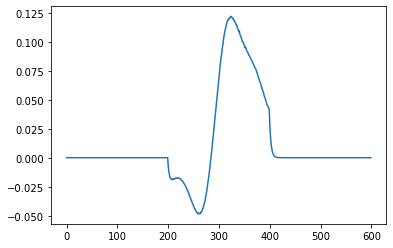

In [64]:
# check the dip in the beginning of the looming disk with constant angular velocity
plt.plot(Ie_T_all[0]-Ii_T2_all[0])
plt.show()

In [59]:
figure_path

'/Volumes/Baohua/research/loom_detection/results/final_figures_for_paper/'

In [62]:
# Now, we want to check the response curves to looming disk with different constant angular velocities
def get_expanding_disk(K, L, pad, dt, v_deg):
    N = K * L
    ro = (N - 1) / 2.
    co = (N - 1) / 2.
    R = 2 * L
    v = (v_deg / 5) * L

    expanding_disk = []
    while R <= (N + 1) / 2:
        one_disk = gKs.get_one_disk(K, L, pad, ro, co, R)
        expanding_disk.append(one_disk)
        R = R + v * dt
    expanding_disk = np.array(expanding_disk)
    
    return expanding_disk

K = 12
L = 50
dt = 0.01
p = 1
pad = 2 * L
delay_dt = 0.03
v_deg = 10
space_filter = flfd.get_space_filter(L/2, 4)
leftup_corners = opsg.get_leftup_corners(K, L, pad)
save_path = '/Volumes/Baohua/data_on_hd/loom/looming_disk_constant_v/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

v_deg_list = [1000, 500, 400, 300, 200, 100, 50, 40, 30, 20]
for v_deg in v_deg_list:
    expanding_disk = get_expanding_disk(K, L, pad, dt, v_deg)
    print(f'The shape of the intensity is {expanding_disk.shape}')
    # calculate the flow field
    UV_flows = gKs.get_UV_flows(space_filter, K, L, pad, dt, delay_dt, leftup_corners, expanding_disk)
    print(f'The shape of the UV_flows is {UV_flows.shape}')
    
    np.save(save_path+f'expanding_disk_{v_deg}', expanding_disk)
    np.save(save_path+f'UV_flows_{v_deg}', UV_flows)

The shape of the intensity is (3, 1, 800, 800)
The shape of the UV_flows is (3, 1, 144, 4)
The shape of the intensity is (5, 1, 800, 800)
The shape of the UV_flows is (5, 1, 144, 4)
The shape of the intensity is (6, 1, 800, 800)
The shape of the UV_flows is (6, 1, 144, 4)
The shape of the intensity is (7, 1, 800, 800)
The shape of the UV_flows is (7, 1, 144, 4)
The shape of the intensity is (11, 1, 800, 800)
The shape of the UV_flows is (11, 1, 144, 4)
The shape of the intensity is (21, 1, 800, 800)
The shape of the UV_flows is (21, 1, 144, 4)
The shape of the intensity is (41, 1, 800, 800)
The shape of the UV_flows is (41, 1, 144, 4)
The shape of the intensity is (51, 1, 800, 800)
The shape of the UV_flows is (51, 1, 144, 4)
The shape of the intensity is (67, 1, 800, 800)
The shape of the UV_flows is (67, 1, 144, 4)
The shape of the intensity is (101, 1, 800, 800)
The shape of the UV_flows is (101, 1, 144, 4)


In [76]:
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[0]

M = 256
args = {}
args['M'] = M
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['temporal_filter'] = False
args['tau_1'] = 1.

saved_results_path = figure_path+'model_clustering/clusterings/'
model_folders = np.load(saved_results_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)
model_path = model_folders[0][3]+'/'
# model_path = figure_path + 'weights_different_regu/M160/outward/'
print(model_path)

a = np.load(model_path + "trained_a.npy")
b = np.load(model_path + "trained_b.npy")
intercept_e = np.load(model_path + "trained_intercept_e.npy")
tau_1 = np.load(model_path + "trained_tau_1.npy")
weights_e = np.load(model_path + "trained_weights_e.npy")
if model_type == 'inhibitory1' or model_type == 'inhibitory2':
    weights_i = np.load(model_path + "trained_weights_i.npy")
    intercept_i = np.load(model_path + "trained_intercept_i.npy")
weights_intensity = None
if args["use_intensity"]:
    weights_intensity = np.load(model_path + "trained_weights_intensity.npy")
if args['temporal_filter']:
    args['n'] = 1

res_rest_2Fa_all = []
res_T_2Fa_all = []
Ie_T_2Fa_all = []
Ii_T_2Fa_all = []
Ii_T2_2Fa_all = []

for v_deg in v_deg_list:
    data_path =  '/Volumes/Baohua/data_on_hd/loom/looming_disk_constant_v/'
    UV_flow = np.load(data_path+f'UV_flows_{v_deg}.npy', allow_pickle=True)
    frame_intensity = None
    res_rest, res_T, Ie_T, Ii_T, Ii_T2 = hpfn.get_response_with_inhibition2(\
        args, weights_e, weights_i, intercept_e, intercept_i, UV_flow, weights_intensity, frame_intensity)
    res_T_max = (res_T-res_T[0]).max()
    print(res_T_max)
    
    res_rest_2Fa_all.append(res_rest)
    res_T_2Fa_all.append(res_T)
    Ie_T_2Fa_all.append(Ie_T)
    Ii_T_2Fa_all.append(Ii_T)
    Ii_T2_2Fa_all.append(Ii_T2)



/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/set_1256_R1.0/inhibitory2/ACT_0_0.001/False_False_111_20201221045939/
0.0
7.088841915130615
9.375988483428955
9.412335872650146
8.253118991851807
5.205963134765625
2.7795627117156982
2.2396366596221924
1.690051555633545
1.1362676620483398


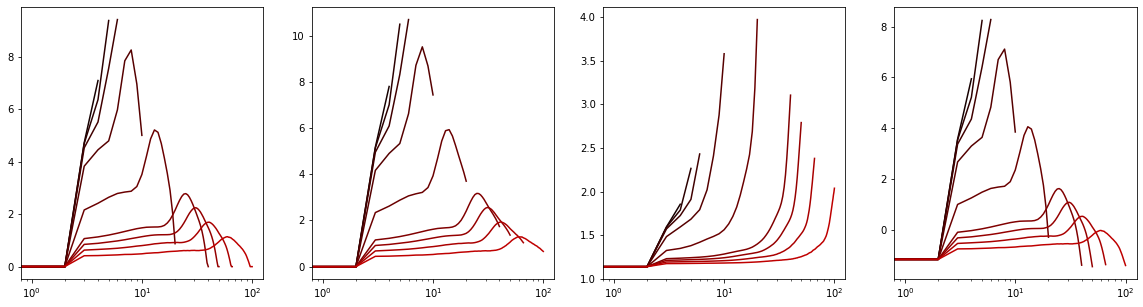

In [80]:
# check the dip in the beginning of the looming disk with constant angular velocity
fig = plt.figure(figsize=(20, 5))
gs0 = gridspec.GridSpec(1, 4, figure=fig)

ll = len(res_T_2Fa_all)
red_scale = [ii/(ll*1.2) for ii in range(ll)]

ax = fig.add_subplot(gs0[0, 0])
for ii, res in enumerate(res_T_2Fa_all):
    ax.plot(res, c=[red_scale[ii], 0, 0])
ax.set_xscale('log')
    
ax = fig.add_subplot(gs0[0, 1])
for ii, res in enumerate(Ie_T_2Fa_all):
    ax.plot(res, c=[red_scale[ii], 0, 0])
ax.set_xscale('log')
    
ax = fig.add_subplot(gs0[0, 2])
for ii, res in enumerate(Ii_T_2Fa_all):
    ax.plot(res, c=[red_scale[ii], 0, 0])
ax.set_xscale('log')
    
ax = fig.add_subplot(gs0[0, 3])
for ii, res in enumerate(Ie_T_2Fa_all):
    ax.plot(res-Ii_T_2Fa_all[ii], c=[red_scale[ii], 0, 0])
ax.set_xscale('log')
    
    
plt.show()

# Hand tuned weights

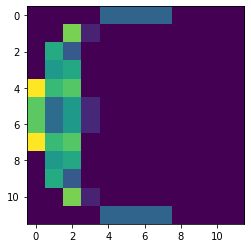

In [123]:
trained_weights_i = np.load('../results/hand_tuned_weights/trained_weights_i.npy')
trained_weights_i_right = np.zeros_like(trained_weights_i[:, 0:1])
trained_weights_i_right[:, :] = trained_weights_i[:, 0:1]

trained_weights_i_right_reshaped = trained_weights_i_right.reshape(12, 12)
# trained_weights_i_right_reshaped[trained_weights_i_right_reshaped>=3] = 10
trained_weights_i_right_reshaped[trained_weights_i_right_reshaped<3] = 0
trained_weights_i_right_reshaped[0, 4:8] = 10
trained_weights_i_right_reshaped[11, 4:8] = 10
# trained_weights_i_right_reshaped[1, 4:10] = 2
# trained_weights_i_right_reshaped[10, 4:10] = 2

plt.imshow(trained_weights_i_right_reshaped)
plt.show()

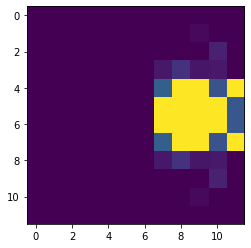

In [124]:
trained_weights_e = np.load('../results/hand_tuned_weights/trained_weights_e.npy')
trained_weights_e_right = np.zeros_like(trained_weights_e[:, 0:1])
trained_weights_e_right[:, :] = trained_weights_e[:, 0:1]

trained_weights_e_right_reshaped = trained_weights_e_right.reshape(12, 12)
trained_weights_e_right_reshaped[trained_weights_e_right_reshaped>1] = 3

plt.imshow(trained_weights_e_right_reshaped)
plt.show()

In [125]:
trained_weights_e_tuned = np.zeros_like(trained_weights_e)
trained_weights_i_tuned = np.zeros_like(trained_weights_i)

rot_numbers = [0, 2, 1, 3]

for ind, rot_n in enumerate(rot_numbers):
    trained_weights_e_right_reshaped_rot = np.rot90(trained_weights_e_right_reshaped, rot_n)
    trained_weights_i_right_reshaped_rot = np.rot90(trained_weights_i_right_reshaped, rot_n)
    trained_weights_e_tuned[:, ind:ind+1] = trained_weights_e_right_reshaped_rot.reshape(144, 1)
    trained_weights_i_tuned[:, ind:ind+1] = trained_weights_i_right_reshaped_rot.reshape(144, 1)
file_name_e = '../results/hand_tuned_weights/trained_weights_e_tuned.npy'
file_name_i = '../results/hand_tuned_weights/trained_weights_i_tuned.npy'
np.save(file_name_e, trained_weights_e_tuned)
np.save(file_name_i, trained_weights_i_tuned)

In [127]:
importlib.reload(hpfn)

figuretypes1 = ['2F', '3e', '3f', '4A', '4C', '4E', '4G']

figuretypes2 = \
[['2Fa', '2Fb', '2Fc', '2Fd', '2Fe', '2Ff', '2Fg'], \
 ['3e1', '3e2', '3e3', '3e4', '3e5', '3e6', '3e7', '3e8', '3e9', '3e10', '3e11', '3e12'], \
 ['3f1', '3f2', '3f3', '3f4', '3f5', '3f6', '3f7', '3f8', '3f9', '3f10', '3f11', '3f12'], \
 ['4Aa', '4Ab', '4Ac'], \
 ['4Ca', '4Cb', '4Cc', '4Cd', '4Ce'], \
 ['4E10', '4E20', '4E60'], \
 ['4Ga', '4Gb', '4Gc', '4Gd', '4Ge']]

labels_2F = np.zeros(7)
labels_2F[0] = 1

labels_3e = np.zeros(12)
labels_3f = np.zeros(12)

labels_4A = np.zeros(3)
labels_4A[0] = 1
labels_4C = np.zeros(5)
labels_4E = np.zeros(3)
labels_4G = np.zeros(5)

labels_T = [labels_2F, labels_3e, labels_3f, labels_4A, labels_4C, labels_4E, labels_4G]

ymin = -0.1
ymax_dict = {}
ymax_dict['3e'] = 0.4
ymax_dict['3f'] = 1.5
ymax_dict['4A'] = 1
ymax_dict['4C'] = 0.3
ymax_dict['4E'] = 0.6
ymax_dict['4G'] = 0.1


model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
model_type = model_types[3]

filter_types = ['outward', 'inward']
filter_type = filter_types[0]

M = 160
args = {}
args['M'] = M
args["n"] = 0
args["dt"] = 0.01
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['temporal_filter'] = False
args['tau_1'] = 1.

model_path = '../results/hand_tuned_weights/'
print(model_path)
data_path =  '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50_2/Klapoetke_UV_flows/2F/Klapoetke_UV_flows_2Fa.npy'
UV_flow = np.load(data_path, allow_pickle=True)
_, res_T_2Fa, _, _ = hpfn.get_response_over_time(args, model_path, model_type, UV_flow, intensity=0)
res_T_2Fa_max = (res_T_2Fa-res_T_2Fa[0]).max()

if os.path.isdir(model_path):
    for ind, figuretype in enumerate(figuretypes1):
        data_path =  '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50_2/Klapoetke_UV_flows/'+figuretype+'/'
        UV_flow_files = [data_path+'Klapoetke_UV_flows_'+file+'.npy' for file in figuretypes2[ind]]
        data_path = '/Volumes/Baohua/data_on_hd/loom/Klapoetke_stimuli_L50_2/Klapoetke_intensities_cg/'+figuretype+'/'
        intensity_files = [data_path+'Klapoetke_intensities_cg_'+file+'.npy' for file in figuretypes2[ind]]

        K = args['K']
        alpha_leak = args['alpha_leak']
        a = np.load(model_path + "trained_a.npy")
        b = np.load(model_path + "trained_b.npy")
        intercept_e = np.load(model_path + "trained_intercept_e.npy")
#         intercept_e = 0
        tau_1 = np.load(model_path + "trained_tau_1.npy")
        weights_e = np.load(model_path + "trained_weights_e_tuned.npy")
        if model_type == 'inhibitory1' or model_type == 'inhibitory2':
            weights_i = np.load(model_path + "trained_weights_i_tuned.npy")
            intercept_i = np.load(model_path + "trained_intercept_i.npy")
#             intercept_i = -0.2
        weights_intensity = None
        if args["use_intensity"]:
            weights_intensity = np.load(model_path + "trained_weights_intensity.npy")
        if args['temporal_filter']:
            args['n'] = 1
        
        res_rest_all = []
        res_T_all = []
        Ie_T_all = []
        Ii_T_all = []
        Ii_T2_all = []
        for ind, UV_flow_file in enumerate(UV_flow_files):
            UV_flow = np.load(UV_flow_file)
            frame_intensity = None
            if args['use_intensity']:
                frame_intensity = np.load(intensity_files[ind])
                assert(len(frame_intensity) == len(UV_flow_))
            if model_type == 'excitatory':
                res_T = hpfn.get_response_excitatory_only(\
                    args, weights_e, intercept_e, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'excitatory_WNR':
                res_T = hpfn.get_response_excitatory_only(\
                    args, weights_e, intercept_e, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'inhibitory1':
                res_T = hpfn.get_response_with_inhibition1(\
                    args, weights_e, weights_i, intercept_e, intercept_i, a, b, UV_flow, weights_intensity, frame_intensity)
            elif model_type == 'inhibitory2':
                res_rest, res_T, Ie_T, Ii_T, Ii_T2 = hpfn.get_response_with_inhibition2(\
                    args, weights_e, weights_i, intercept_e, intercept_i, UV_flow, weights_intensity, frame_intensity)
            res_rest_all.append(res_rest)
            res_T_all.append(res_T)
            Ie_T_all.append(Ie_T)
            Ii_T_all.append(Ii_T)
            Ii_T2_all.append(Ii_T2)
        filename = figure_path+'klap_replication/'+figuretype+'_M{}_h'.format(M)
        np.savez(filename, res_rest_all, res_T_all, Ie_T_all, Ii_T_all, Ii_T2_all)
            
                    

../results/hand_tuned_weights/


# Linear law

In [18]:
# Here, we study the linear relationship between peak time and R/v.

%matplotlib inline

importlib.reload(opsg)
importlib.reload(flfd)
importlib.reload(hpfn)

M = 1
R = 1 # radius of the ball (m)
Rs = np.array([R])
dt = 0.001 # time step (sec)
dynamics_fun = dn3d.dynamics_fun_zero_field # dynamics that is imposed on the object
eta_1 = 0. # random force added on the ball (m/sec^2)
sigma = 0. # noise added to images
theta_r = np.deg2rad(30) # half of the receptive field width (rad)
K = 12 # K*K is the total number of elements
L = 4 # L is the dimension of each element
sample_dt = 0.001 # sampling resolution
delay_dt = 0.03 # delay in the motion detector
D_max = 6.1*R # maximum initial distance (m)

if M == 1:
    lplc2_units_coords = np.array([[0, 0, 1]])
else:
    _, lplc2_units_coords = opsg.get_lplc2_units(M)

data_type = 'hit'
R_over_v_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

for R_over_v in R_over_v_list:
    x = lplc2_units_coords[0][0]
    y = lplc2_units_coords[0][1]
    z = lplc2_units_coords[0][2]
    x, y, z = 1.1 * hpfn.get_normalized_vector([x, y, z])
    vx = x * R / R_over_v
    vy = y * R / R_over_v
    vz = z * R / R_over_v
    traj, distance = smgnmu.generate_one_trajectory_hit(M, R, D_max, theta_r, dt, dynamics_fun, eta_1, x, y, z, vx, vy, vz)

    print(f'The length of the trajectory is {len(traj)}.')

    N = K*L + 4*L # Size of each frame, the additional 4*L is for spatial filtering and will be deleted afterwards.
    pad = 2*L
    leftup_corners = opsg.get_leftup_corners(K, L, pad)
    coord_y = np.arange(N) - (N-1)/2.
    coord_x = np.arange(N) - (N-1)/2.
    coords_y, coords_x = np.meshgrid(coord_y, -coord_x) # coordinates of each point in the frame
    dm = np.sqrt(coords_y**2 + coords_x**2) # distance matrix
    theta_r = np.deg2rad(30) # half of the receptive field width (rad)
    myheat = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)
    space_filter = flfd.get_space_filter(L/2, 4)
    theta_matrix, phi_matrix = opsg.get_angle_matrix(theta_r, coords_x, coords_y, dm, K, L)
    coord_matrix = opsg.get_coord_matrix(phi_matrix, theta_matrix, 1.)

    _, intensities_sample_cg, UV_flow_sample, _ = \
        hpfn.generate_one_sample_exp(M, Rs, traj, sigma, theta_r, space_filter, K, L, dt, sample_dt, delay_dt)
    steps = len(intensities_sample_cg)
    print(f'The length of the movie is {steps}.')

    save_path = '/Volumes/Baohua/data_on_hd/loom/linear_law/'+data_type+'/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    np.save(save_path+f'traj_{R_over_v}_M{M}', traj)
    np.save(save_path+f'distance_{R_over_v}_M{M}', distance)
    np.save(save_path+f'intensities_sample_cg{R_over_v}_M{M}', intensities_sample_cg)
    np.save(save_path+f'UV_flow_sample_{R_over_v}_M{M}', UV_flow_sample)


The length of the trajectory is 46.
The length of the movie is 45.
The length of the trajectory is 91.
The length of the movie is 90.
The length of the trajectory is 182.
The length of the movie is 181.
The length of the trajectory is 364.
The length of the movie is 363.
The length of the trajectory is 455.
The length of the movie is 454.
The length of the trajectory is 546.
The length of the movie is 545.
The length of the trajectory is 637.
The length of the movie is 636.
The length of the trajectory is 728.
The length of the movie is 727.
The length of the trajectory is 819.
The length of the movie is 818.
The length of the trajectory is 910.
The length of the movie is 909.


In [8]:
M = 256

# response, outward filters
model_folders = np.load(figure_path + '/model_clustering/clusterings/model_folders_M{}.npy'.format(M), \
                        allow_pickle=True)
# model
in_or_out = 0 # 0: outward; 1: inward
args = {}
args["n"] = 0
args["dt"] = 0.03
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['M'] = M
args['temporal_filter'] = False
args['tau_1'] = 1.
model_types = ['excitatory', 'excitatory_WNR', 'inhibitory1', 'inhibitory2']
filter_types = ['outward', 'inward']
model_type = model_types[3]
filter_type = filter_types[in_or_out]
model_path = model_folders[in_or_out][16]+'/' # for [0], add _sup1 at the end of the saved file.

data_type = 'hit'
data_path = '/Volumes/Baohua/data_on_hd/loom/linear_law/'+data_type+'/'

# R_over_v_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, \
#                  0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
R_over_v_list = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

# green, yellow green, orange, red
color_list_data = [[0/255., 128/255., 0/255.], \
                   [154/255., 205/255., 50/255.], \
                   [255/255., 165/255., 0], \
                   [255/255., 0, 0]]
color_list = []
for ind, R_over_v in enumerate(R_over_v_list):
    if R_over_v == 0.01:
        color_list.append(color_list_data[0])
    elif R_over_v == 0.02:
        color_list.append(color_list_data[1])
    elif R_over_v == 0.04:
        color_list.append(color_list_data[2])
    elif R_over_v == 0.08:
        color_list.append(color_list_data[3])
    else:
        val = 1. / (len(R_over_v_list) + 5) * ind
        color_list.append([val, val, val])

res_T_all = []
distance_T_all = []
for R_over_v in R_over_v_list:
    M = 256
    file = data_path+f'UV_flow_sample_{R_over_v}_M{M}.npy'
    UV_flow = np.load(file, allow_pickle=True)
    res_rest, res_T, prob, prob_rest = hpfn.get_response_over_time(args, model_path, model_type, UV_flow, intensity=0)
    res_T_all.append(res_T.sum(axis=1))
    
    file = data_path+f'distance_{R_over_v}_M{M}.npy'
    distance = np.load(file, allow_pickle=True)
    distance_T_all.append(distance)
    
save_path = '/Volumes/Baohua/data_on_hd/loom/linear_law/'+data_type+'/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

np.save(save_path+f'distance_T_all_M{M}_1', distance_T_all)
np.save(save_path+f'res_T_all_M{M}_1', res_T_all)


In [6]:
model_path

'/Volumes/Baohua/research_large_files/multi_lplc2_training_D5/M_256/lr_0.001/regu_0.0001/seed_156_20210619111917/'

# HRC motion estimator

## Tuning curves: moving edge as an example

In [4]:
def get_moving_edge(K, L, pad, dt, v_deg):
    N = K * L
    ro = -L
    co = (N - 1) / 2.
    theta_a = np.pi * 1.5
    L1 = 0
    L2 = (N - 1) / 2.
    L3 = 0
    L4 = (N - 1) / 2.
    v = (v_deg / 5) * L
    
    moving_edge = []
    while L1 <= N - ro:
        one_bar = gKs.get_one_bar(K, L, pad, ro, co, theta_a, L1, L2, L3, L4)
        moving_edge.append(one_bar)
        L1 = L1 + v * dt
    moving_edge = np.array(moving_edge)
    
    return moving_edge


def animation_by_clear_output(img_roll, interval=10, sleep_time=0):
    T = len(img_roll)
    v_max = np.abs(img_roll).max()
    
    plt.figure()
    for t in range(0, T, interval):
        plt.imshow(img_roll[t], 'gray_r', vmin=-v_max, vmax=v_max)
        plt.show()
        sleep(sleep_time)
        clear_output(wait=True)

In [6]:
K = 12
L = 50
dt = 0.01
p = 1
pad = 2 * L
delay_dt = 0.03
v_deg = 20

moving_edge = get_moving_edge(K, L, pad, dt, v_deg)
print(f'The shape of the intensity is {moving_edge.shape}')

# calculate the flow field
space_filter = flfd.get_space_filter(L/2, 4)
leftup_corners = opsg.get_leftup_corners(K, L, pad)
UV_flows = gKs.get_UV_flows(space_filter, K, L, pad, dt, delay_dt, leftup_corners, moving_edge)
print(f'The shape of the UV_flows is {UV_flows.shape}')

The shape of the intensity is (325, 1, 320, 320)
The shape of the UV_flows is (325, 1, 144, 4)


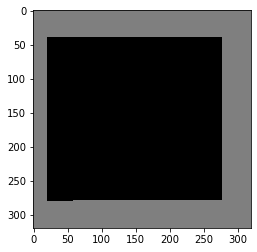

In [7]:
# visualize the intensity flow and flow field
img_roll = np.squeeze(moving_edge)
animation_by_clear_output(img_roll)

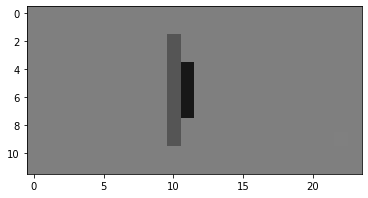

In [8]:
# visualize the flow field, left: horizontal, right: vertical.
T = UV_flows.shape[0]
cf_uvs = []
for t in range(T):
    cf_u, cf_v = flfd.set_flow_fields_on_frame(UV_flows[t], leftup_corners, K, L, pad)
    cf_uvs.append(np.concatenate((np.squeeze(cf_u), np.squeeze(cf_v)), axis=1))
cf_uvs = np.array(cf_uvs)

img_roll = cf_uvs
animation_by_clear_output(img_roll)

In [9]:
# This cell takes 5-20 minutes to run depending on the value of L

importlib.reload(opsg)
importlib.reload(flfd)
importlib.reload(hpfn)
importlib.reload(gKs)

# Tuning curves of the HRC model
K = 12
L = 10
dt = 0.001
p = 1
pad = 2 * L
delay_dt = 0.03
start_time = time.time()
space_filter = flfd.get_space_filter(L/2, 4)
leftup_corners = opsg.get_leftup_corners(K, L, pad)

UV_averaged = []
v_deg_list = range(5, 1001, 5)
for v_deg in v_deg_list:
    # intensity
    moving_edge = get_moving_edge(K, L, pad, dt, v_deg)
    # calculate the flow field
    UV_flows = gKs.get_UV_flows_exp(space_filter, K, L, pad, dt, delay_dt, leftup_corners, moving_edge)
    
    UV_averaged.append(UV_flows[UV_flows > 0].mean())
print(f'This takes {time.time()-start_time}.')
    
save_path = figure_path + '/hrc_tuning/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

np.save(save_path+f'UV_averaged_moving_edge_L{L}_exp', UV_averaged)
np.save(save_path+'v_deg_list', np.array(v_deg_list))

This takes 1097.6194489002228.


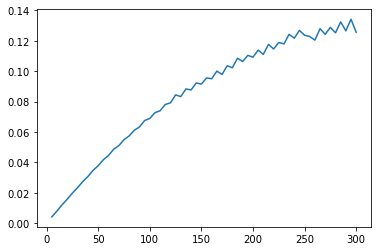

In [126]:
plt.plot(v_deg_list[::-1], UV_averaged[::-1])
plt.show()

## Distributions of HRC outputs

In [624]:
# All HRC output

importlib.reload(hpfn)

M = 32
set_number = np.int(1000 + M)
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_scal200_D5/set_{}/'.format(set_number)
data_types = ['hit', 'miss', 'retreat', 'rotation']

V_hit, V_miss, V_retreat, V_rotation = hpfn.get_velocity_all(data_path, data_types)

save_path = figure_path + '/hrc_tuning/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

np.savez(save_path+f'HRC_output_M{M}_old', V_hit, V_miss, V_retreat, V_rotation)

In [10]:
bz = {0:1, 16:2}

In [11]:
bz

{0: 1, 16: 2}

In [13]:
'str'+'_h'

'str_h'